# Finding Exoplanets with Python

## What is the transit method??
![](pictures/phase_curve.png)
The transit method is one of the many techniques for detecting exoplanets. This method makes use of the observation of periodic dips of light in a star, which are caused by a planet passing in front of it, which blocks a portion on the light emmitted. 

### How does the transit method work?
1. **Observing Dips in light**: As the planet orbits its parent star, it causes a temporary decrease in the star's brightness. The depth of the dip will correspond to the size of the planet.
2. **Determining Orbital Period**: The Time interval between successive transits allows astronomers to calculate the planet's orbital period, which can help determine the distance between the planet and the star(based on Kepler's Laws of planetary motion)
3. **Planet Characterisation**: The transit method can also provide valuable information about the planet's physical characteristics. By analysing the light that passes through the planet's atmosphere during a transit, scientists can infer it's chemical composition. 
4. **Follow up observations**: To confirm a planet as a candidate, astronomers require multiple transits. 

In [1]:
# Import dependencies
import matplotlib.pyplot as plt 
from lightkurve import search_targetpixelfile
from lightkurve import TessTargetPixelFile
from lightkurve import search_lightcurve
import lightkurve as lk
import numpy as np
from reference_finder import reference_finder
%matplotlib inline

## What is a Target Pixel File?
Target Pixel Files(or TPFs) are data structures that contain the original imaging data obtained from the space telescopes like kepler, k2 and TESS. Now we will download the files of the subject that we wish to study. 

In [2]:
pixelFile = search_targetpixelfile("KIC 6922244", author="Kepler", cadence="long", quarter=4).download()

* 6922244 is the star we will be looking at(KIC6922244), also known as Kepler-8
* Quarter stands for a time frame. each year has 4 quarters, this means that we are looking at data from the 1st year of the kepler mission. 

<Axes: title={'center': 'Target ID: 6922244, Cadence: 11958'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

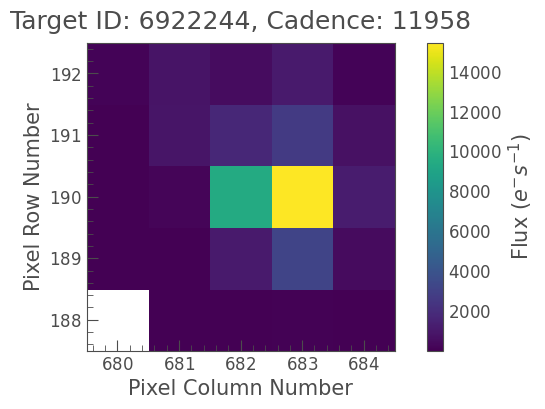

In [3]:
pixelFile.plot(frame=42)

Looking at these graphs is pretty fun, but overall useless on their own, so we'll need to convert these frames into a graph(<b>AKA</b> a light curve)

Aperture masks make the image better to analyse. 

Text(0.5, 1.0, 'Flux over time')

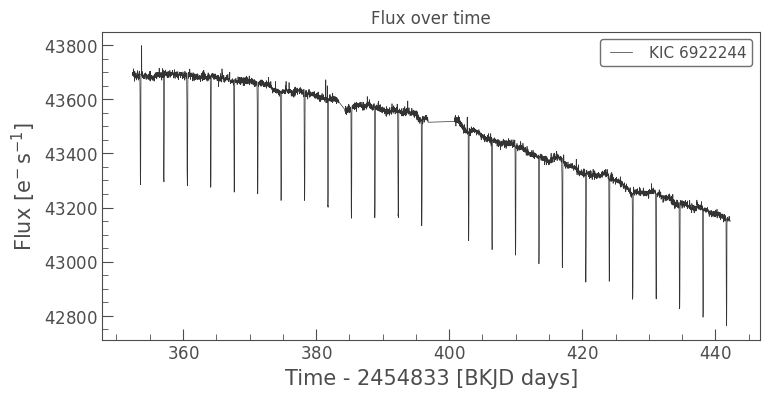

In [4]:
lc = pixelFile.to_lightcurve(aperture_mask=pixelFile.pipeline_mask)
lc.plot()
plt.title('Flux over time')

From this light curve, we can see periodic dips in the luminosity of Kepler-8. From this we can ascertain that <b>something</b> is orbiting the star. For some reason, the overall luminosity of the star seems to be decreasing. This can be due to multiple factors: 
* Maybe the telescope was moving away from the star during observation(this data is recorded from the [Kepler space telescope](https://en.wikipedia.org/wiki/Kepler_space_telescope))
* Maybe a dust cloud? 
* Astrophage? :P

However, the overall luminosity dropping makes it harder for us to analyse the star, therefore we need to make use of the below command. 

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

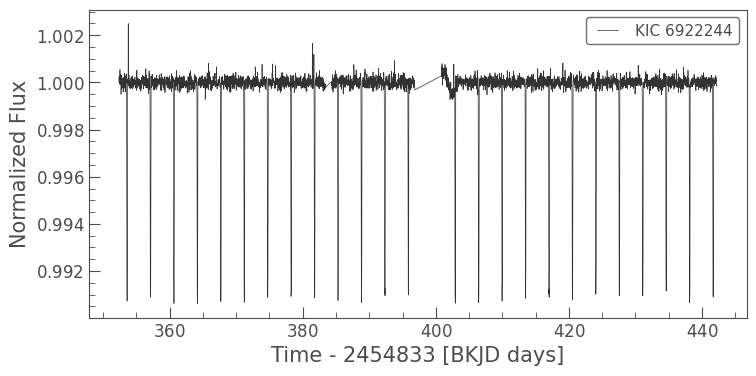

In [5]:
flat_lc = lc.flatten()
flat_lc.plot()

We now phase fold the light curve to verify that the period and the transit time correspond to the transit signal. Essentially the result is the frequency spikes are folded on each other if the period is correct. 

### But what is Phase Folding?

But how do we ascertain the correct period? We make use of a statistical analysis called a [periodogram](https://en.wikipedia.org/wiki/Periodogram)(a periodogram is an estimate of the spectral density of the signal). This essentially shows all the repititive patterns in your graph, and gives you a most likely candidate. 

<Axes: xlabel='Period [$\\mathrm{d}$]', ylabel='BLS Power'>

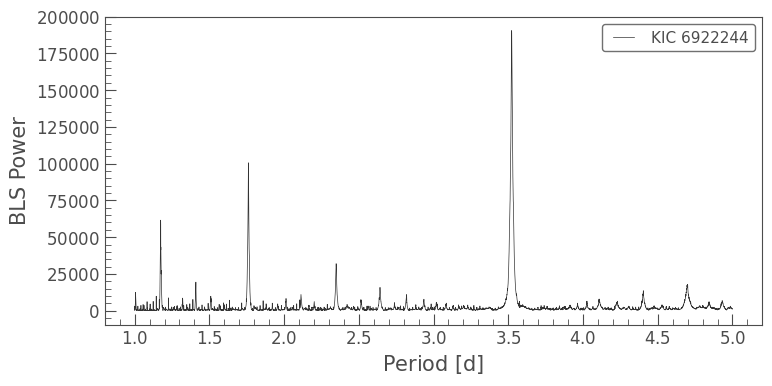

In [6]:
period = np.linspace(1,5,10000)
# BLS = Box Least Squares
bls = lc.to_periodogram(method="bls", period=period, frequency_factor=500)
bls.plot()

We'll now take the period with the highest peak, and that is what we will use for phase folding the light curve. 

In [7]:
highest_peak = bls.period_at_max_power
print(f"Period of highest peak in periodogram: {highest_peak}")
highest_peak_transit_time = bls.transit_time_at_max_power
print(f"Transit time of highest peak in periodogram: {highest_peak_transit_time}")
highest_peak_duration = bls.duration_at_max_power
print(f"Duration of highest peak in periodogram: {highest_peak_duration}")

Period of highest peak in periodogram: 3.522652265226523 d
Transit time of highest peak in periodogram: 353.60132485035285
Duration of highest peak in periodogram: 0.1 d


We'll use the highest peak period to make a folded light curve. 

<Axes: xlabel='Phase [JD]', ylabel='Normalized Flux'>

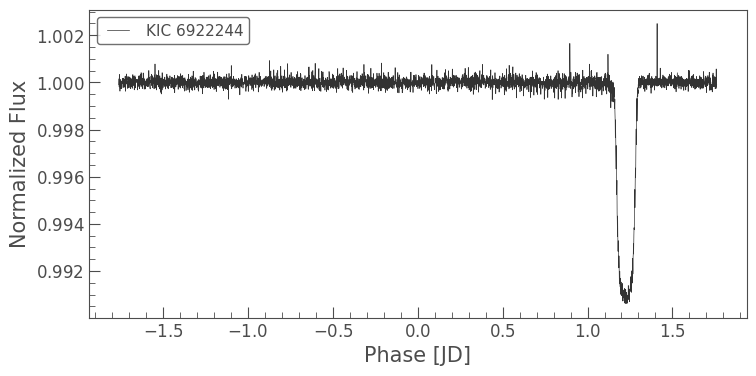

In [8]:
folded_lc = flat_lc.fold(period=highest_peak)
folded_lc.plot()

We can make an alternate light curve that is a scatter plot. 

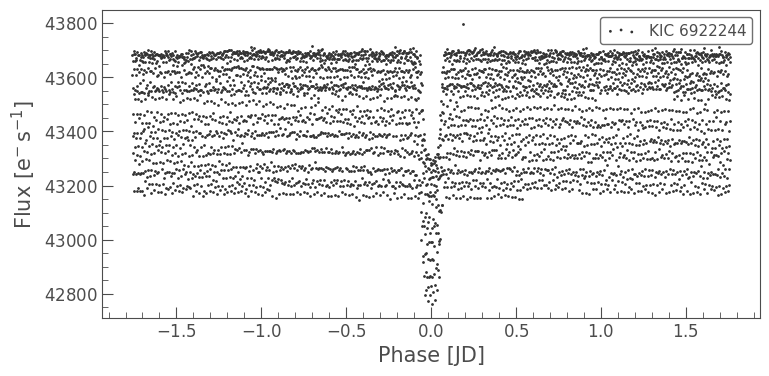

In [9]:
scatter_lc = lc.fold(period=highest_peak, epoch_time=highest_peak_transit_time).scatter()

## Analysing Various stars

#### TESS Data: 
> [https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html)

Use this link to access TESS data(this is updated more regularly. (TESS CTL mission, advanced search)

- Distance: 12-24 parsec
- T_eff(Temperature): 2200-3500

Use this [link](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html?searchQuery=%7B%22service%22%3A%22CTLFILTERED%22%2C%22inputText%22%3A%5B%7B%22paramName%22%3A%22Teff%22%2C%22niceName%22%3A%22Teff%22%2C%22values%22%3A%5B%7B%22min%22%3A2200%2C%22max%22%3A3500%7D%5D%2C%22valString%22%3A%22%5B2200%2C%203500%5D%22%2C%22isDate%22%3Afalse%2C%22facetType%22%3A%22numeric%22%2C%22min%22%3A2200%2C%22max%22%3A3500%2C%22displayString%22%3A%22%5B2200%2C%203500%5D%22%7D%2C%7B%22paramName%22%3A%22d%22%2C%22niceName%22%3A%22d%22%2C%22values%22%3A%5B%7B%22min%22%3A12%2C%22max%22%3A24%7D%5D%2C%22valString%22%3A%22%5B12%2C%2024%5D%22%2C%22isDate%22%3Afalse%2C%22facetType%22%3A%22numeric%22%2C%22min%22%3A12%2C%22max%22%3A24%2C%22displayString%22%3A%22%5B12%2C%2024%5D%22%7D%5D%2C%22position%22%3A%22undefined%2C%20undefined%2C%20undefined%22%2C%22paramsService%22%3A%22Mast.Catalogs.Filtered.Ctl.Rows%22%2C%22title%22%3A%22CTL%20v8.01%3A%20%20Advanced%20Search%201%22%2C%22tooltip%22%3A%22%5B2200%2C%203500%5D%3B%20%5B12%2C%2024%5D%3B%20%22%2C%22columns%22%3A%22*%22%7D) to directly perform the search with the above parameters.

In [10]:
def analyse_star(star, mission, compact=False, author=None, exptime=None, targetPixelFile=False):
    '''
    A helper function to plot all the graphs for a particular star. 
    Parameters:
    star(str): The star that is being studied.
    mission(str): The mission to be specified(TESS, Kepler etc).
    author(str): The origin of that data(Kepler, TESS etc).
    exptime(int): Specify this if you want to constrain search results by exposure time.
    compact(bool): Specify True if you want the graphs to be in a compact format.
    targetPixelFile(bool): Specify True if you want to use targetpixelfiles for analysis. 
    '''
    search_result = None
    if author: 
        search_result = search_lightcurve(star, mission=mission, author=author)
    elif exptime:
        search_result = search_lightcurve(star, mission=mission, exptime=exptime)
    elif author and exptime:
        search_result = search_lightcurve(star, mission=mission, author=author, exptime=exptime)
    else:
        search_result = search_lightcurve(star, mission=mission)
    print(search_result)
    choice = input('Which result do you want to download? Type Stitch if you want to use multiple sectors of data: ')
    if 'STITCH'.lower() in choice:
        pixelFile = sector_stitcher(search_result)
    else:
        pixelFile = search_result[int(choice)].download()
    
    # Get the Lightcurve
    lc = None
    if targetPixelFile:
        lc = pixelFile.to_lightcurve(aperture_mask=pixelFile.pipeline_mask)
    else:
        lc = pixelFile
    
    # Flatten Lightcurve
    flat_lc = lc.flatten()
    
    # Obtain Periodogram
    period = np.linspace(1,5,10000)
    bls = lc.to_periodogram(method="bls", period=period, frequency_factor=500) # BLS = Box Least Squares
    highest_peak = bls.period_at_max_power
    print(f"Period of highest peak in periodogram: {highest_peak}")
    highest_peak_transit_time = bls.transit_time_at_max_power
    print(f"Transit time of highest peak in periodogram: {highest_peak_transit_time}")
    highest_peak_duration = bls.duration_at_max_power
    print(f"Duration of highest peak in periodogram: {highest_peak_duration}")
    folded_lc = flat_lc.fold(period=highest_peak)

    if compact:
        fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15,10))
        lc.plot(ax=ax[0,0], color='black') # Flux over time
        ax[0,0].set_title('Luminosity over Time')
        
        flat_lc.plot(ax=ax[0,1], color='black') # Flattened Lightcurve
        ax[0,1].set_title('Luminosity over Time(Flattened)')
        
        bls.plot(ax=ax[1,0], color='black') # Periodogram
        ax[1,0].set_title('Periodogram')
        
        folded_lc.plot(ax=ax[1,1], color='black') # Folded lightcurve
        ax[1,1].set_title('Folded Lightcurve') 
        lc.fold(period=highest_peak, epoch_time=highest_peak_transit_time).scatter(ax=ax[2,0], color='black')
        
        ax[2,0].set_title('Scatter Lightcurve plot') # Scattered Lightcurve plot
        fig.delaxes(ax[2,1]) # The indexing is zero-based here
        fig.suptitle(f'Overview of {star}')
        plt.tight_layout()
    else: 
        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5, ncols=1, figsize=(8,16))
        lc.plot(ax=ax1, color='black') # Flux over time
        ax1.set_title('Luminosity over Time')
        
        flat_lc.plot(ax=ax2, color='black') # Flattened Lightcurve
        ax2.set_title('Luminosity over Time(Flattened)')
        
        bls.plot(ax=ax3, color='black') # Periodogram
        ax3.set_title('Periodogram')
        
        folded_lc.plot(ax=ax4, color='black') # Folded lightcurve
        ax4.set_title('Folded Lightcurve') 
        lc.fold(period=highest_peak, epoch_time=highest_peak_transit_time).scatter(ax=ax5, color='black')
        ax5.set_title('Scatter Lightcurve plot') # Scattered Lightcurve plot
        plt.tight_layout()
    return lc

In [11]:
def sector_stitcher(search_results):
    '''
    A simple function to stitch multiple sectors of observation data. 
    Parameters:
    search_results(lightkurve.SearchResult): The search result of all the data products for the queried star. 
    '''
    sectors = input('Enter the range of sectors you want to stitch together: ')
    sectors = sectors.split('-')
    sector_range = search_results[int(sectors[0]):int(sectors[1])]
    lc_collection = sector_range.download_all()
    lc_collection_stitched = lc_collection.stitch()
    return lc_collection_stitched

SearchResult containing 19 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 23 2020   SPOC     120   284475976      0.0
  1 TESS Sector 26 2020   SPOC     120   284475976      0.0
  2 TESS Sector 40 2021   SPOC     120   284475976      0.0
  3 TESS Sector 41 2021   SPOC     120   284475976      0.0
  4 TESS Sector 56 2022   SPOC      20   284475976      0.0
  5 TESS Sector 60 2022   SPOC      20   284475976      0.0
  6 TESS Sector 55 2022   SPOC     120   284475976      0.0
  7 TESS Sector 53 2022   SPOC     120   284475976      0.0
  8 TESS Sector 56 2022   SPOC     120   284475976      0.0
  9 TESS Sector 60 2022   SPOC     120   284475976      0.0
 10 TESS Sector 54 2022   SPOC     120   284475976      0.0
 11 TESS Sector 73 2023   SPOC      20   284475976      0.0
 12 TESS Sector 73 2023   SPOC     120   284475976      0

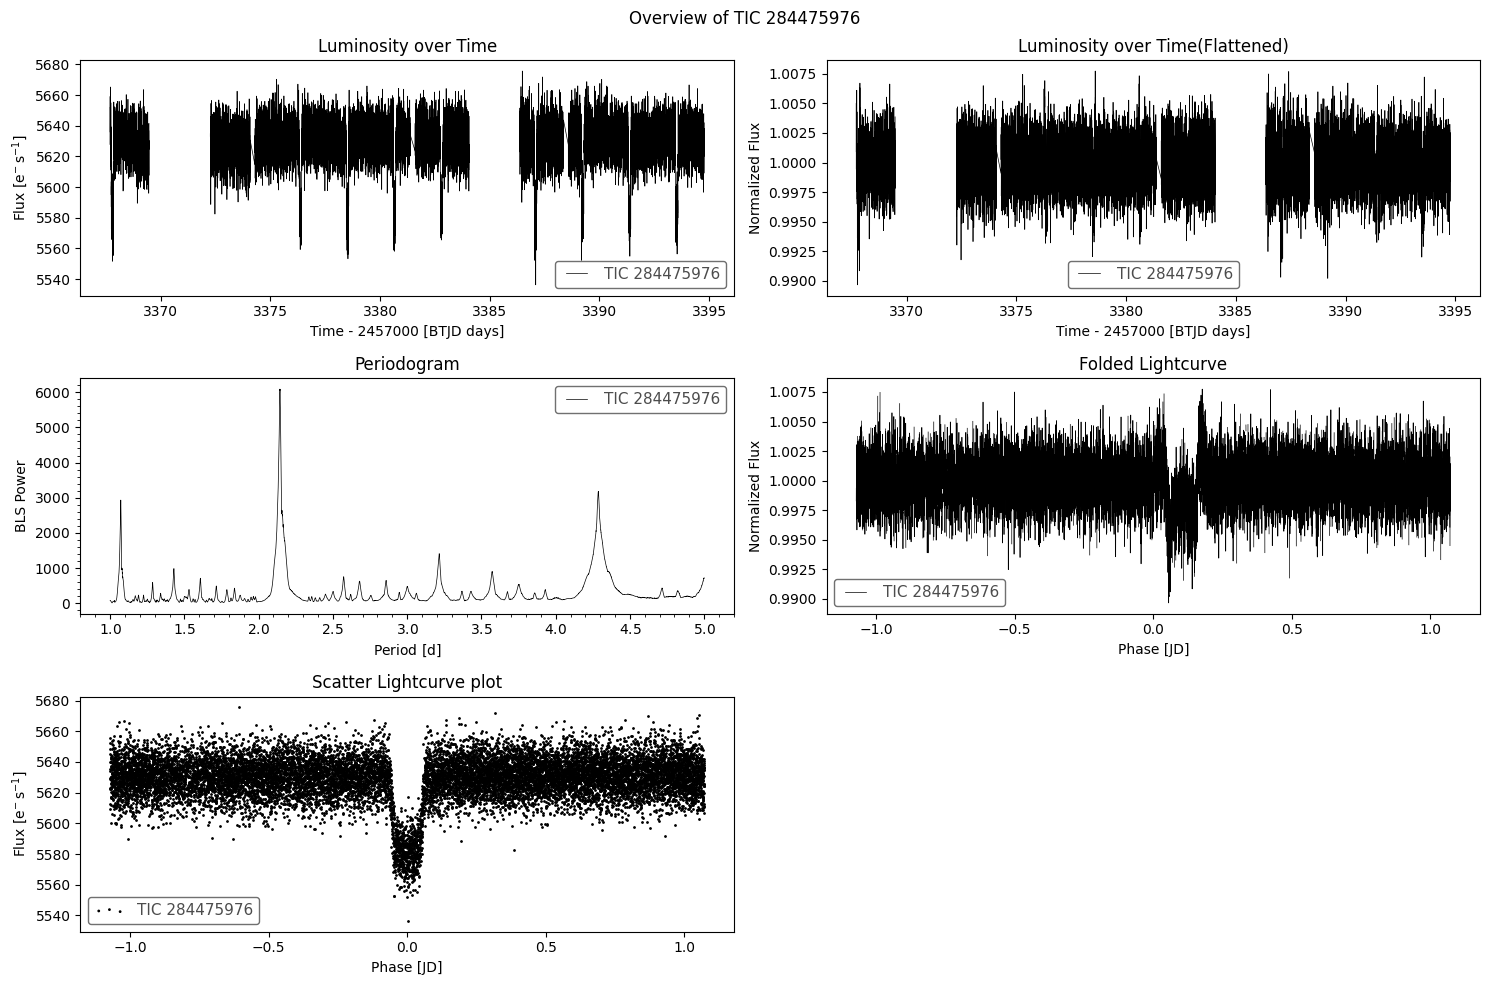

In [12]:
star = 'TIC 284475976'
light_curve = analyse_star(star=star, mission='TESS', compact=True, author='SPOC')